# Plane CV 

The goal here is to try to establish flying speed from camera images. 

The grand idea is to: 
- identify plane
- determine its specs (wingspan etc) 
- measure the increase in wingspan over time
- calculate and display speed on the video

![early notes](img/planeCV.jpg)


# Unity simulation
- plane models 
- jitter images to create a large data set 
- train a deep model to recognize planes 
- randomly generate planes to come down the runway
- random speeds within a plausible range 
- in game camera detects plane
- then identifies it and begins to calculate the speed based on pixels 
- then tracks it (using skillz from udacity) 

# Processing each image

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import scipy

In [7]:
# getting a couple of frames from a subclip for some analysis
clip1 = VideoFileClip("baron_beacon_approach.mp4")

# making a smaller subclip for time sake
# test_clip = clip1.subclip(10,15)

test_clip.save_frame("frame1.png") # saves the first frame
test_clip.save_frame("frame2.png", t=5) # saves the frame a t=2s

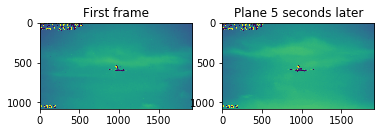

In [145]:
# plotting the two images 
# Plot the examples
frame1 = cv2.imread("frame1.png",0)
frame2 = cv2.imread("frame2.png",0)

fig = plt.figure()
plt.subplot(121)
plt.imshow(frame1)
plt.title('First frame')
plt.subplot(122)
plt.imshow(frame2)
plt.title('Plane 5 seconds later')
plt.savefig('Plane_5_seconds.png',transparent=True)

In [146]:
frame1.shape

(1080, 1920)

In [147]:
frame1

array([[ 68,  68,  70, ...,  68,  68,  68],
       [ 68,  68,  68, ...,  70,  68,  68],
       [ 68,  68,  67, ...,  70,  68,  68],
       ..., 
       [ 92,  92,  93, ..., 109, 108, 108],
       [ 92,  93,  93, ..., 109, 110, 110],
       [ 92,  94,  94, ..., 110, 111, 111]], dtype=uint8)

In [148]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [201]:
# so what I am starting with is simply a measurement from one frame to the next
# divided by delta t to get a sort of velocity measurement

# 1. convert to gray
# 2. gaussian blur
# 3. sobel gradients and binary image
# 4. canny
# 5. findCountours



# gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(frame1,(7,7),0)

# edges = cv2.Canny(frame1, 50, 100)

sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 3)

abs_sobel_x = np.absolute(sobel_x)
abs_sobel_y = np.absolute(sobel_y)

scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))


thresh = (10,255)
sx_binary = np.zeros_like(scaled_sobel_x)
sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  

sy_binary = np.zeros_like(scaled_sobel_y)
sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(sx_binary)
combined_binary[(sx_binary == 1) | (sx_binary == 1)] = 1


vertices = np.array([[(0,200),(1920, 200), (1920,1000), (0,1000)]], dtype=np.int32) # also this works without "dtype"
roi = region_of_interest(combined_binary, vertices)

roi = cv2.dilate(roi, None, iterations=10)
roi = cv2.erode(roi, None, iterations=10)

# # imgray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
# # ret, thresh = cv2.threshold(, 127, 255, 0)
# im2, contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# # # drawing contours
# cnt = contours[50]
# contours = cv2.drawContours(roi, [cnt], -1, (0,255,0), 3)


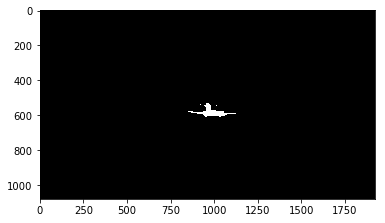

In [202]:
plt.imshow(roi, cmap="gray")

## Final image processing function

In [121]:
def process_frame(frame):
    
    
    
    
    
    
    
    
    return frame

# Processing the Video 

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
# running the pipeline on the video
# output_name = 'project_video_output_newprocess.mp4'
# clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("baron_beacon_approach.mp4")

# making a smaller subclip for time sake
test_clip = clip1.subclip(10,15)
test_clip.write_videofile('sub_clip.mp4', audio= False)

# output_clip = clip1.fl_image(process_image)
# output_clip.write_videofile('test_output.mp4', audio= False)

[MoviePy] >>>> Building video sub_clip.mp4
[MoviePy] Writing video sub_clip.mp4


 99%|█████████▉| 150/151 [00:06<00:00, 24.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sub_clip.mp4 



# References
Websites:
http://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/


Various Docs (for future reference):
https://zulko.github.io/moviepy/getting_started/efficient_moviepy.html